## 패키지 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# -*- coding: 949 -*-

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 80 kB/s 


In [ ]:
import seaborn as sns

In [ ]:
import pandas as pd
from pandas import Series, DataFrame
import glob
import os
import numpy as np
# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import platform
import random
import math
from typing import List ,Dict, Tuple

import sklearn 
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import f1_score 

from catboost import Pool,CatBoostClassifier

print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")

- os: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
- pandas: 1.3.5
- numpy: 1.21.6
- sklearn: 1.0.2


## 전처리

In [ ]:
#한글 인코딩 에러가 생겨서 , encoding='cp949'을 추가함

lotte = pd.read_csv('/content/gdrive/Shareddrives/22SummerProjects/lotte2.csv', encoding='cp949')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
lotte.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,ma_fem_dv,ages,zon_hlv,pd_nm,clac_hlv_nm,clac_mcls_nm,zon_mcls
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,여성,50대,Z17,남성티셔츠,남성의류,남성의류상의,NaN
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,여성,40대,Z13,기타주방일회용품,주방잡화,주방일회용품,Z13001
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,여성,50대,Z17,남성티셔츠,남성의류,남성의류상의,NaN
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,여성,50대,Z17,남성티셔츠,남성의류,남성의류상의,NaN
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,여성,50대,Z17,남성티셔츠,남성의류,남성의류상의,NaN


영수증 번호, 구매시간, 각종 중분류, 점포코드, 방문일자, 상품명 제거 

In [ ]:
lotte=lotte.drop(['rct_no','de_hr','clac_mcls_nm','br_c','vst_dt','zon_mcls','pd_nm'],axis=1)

날짜를 기준으로 트레인 셋 만들거임. 날짜로 정렬

In [ ]:
data = lotte.sort_values(by=["de_dt"], ascending=[True]) 

In [ ]:
data.head()

,cust,chnl_dv,cop_c,pd_c,de_dt,buy_am,buy_ct,ma_fem_dv,ages,zon_hlv,clac_hlv_nm
4479154,M495972460,2,C01,NaN,20201227,26000.0,NaN,남성,40대,Z10,NaN
4577506,M039320884,2,C01,NaN,20201229,6500.0,NaN,여성,40대,Z06,NaN
4405455,M192531170,2,C01,NaN,20201229,10000.0,NaN,여성,40대,Z10,NaN
4506528,M864132607,2,C01,NaN,20201230,15000.0,NaN,여성,70대,Z14,NaN
4522622,M201983289,2,C01,NaN,20201230,24000.0,NaN,남성,40대,Z10,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4630047 entries, 4479154 to 4529916
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   cust         object 
 1   chnl_dv      int64  
 2   cop_c        object 
 3   pd_c         object 
 4   de_dt        int64  
 5   buy_am       float64
 6   buy_ct       float64
 7   ma_fem_dv    object 
 8   ages         object 
 9   zon_hlv      object 
 10  clac_hlv_nm  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 423.9+ MB


In [ ]:
data['de_dt']= data['de_dt'].astype('str')

In [ ]:
from datetime import datetime, timedelta

In [ ]:
data['de_dt']=data['de_dt'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))

In [ ]:
data.head()

,cust,chnl_dv,cop_c,pd_c,de_dt,buy_am,buy_ct,ma_fem_dv,ages,zon_hlv,clac_hlv_nm
4479154,M495972460,2,C01,NaN,2020-12-27,26000.0,NaN,남성,40대,Z10,NaN
4577506,M039320884,2,C01,NaN,2020-12-29,6500.0,NaN,여성,40대,Z06,NaN
4405455,M192531170,2,C01,NaN,2020-12-29,10000.0,NaN,여성,40대,Z10,NaN
4506528,M864132607,2,C01,NaN,2020-12-30,15000.0,NaN,여성,70대,Z14,NaN
4522622,M201983289,2,C01,NaN,2020-12-30,24000.0,NaN,남성,40대,Z10,NaN


In [ ]:
data['clac_hlv_nm'].value_counts()

과자            440223
채소            423178
대용식           311966
유제품           284420
냉장식품          266481
음료            250179
과일            231090
축산물           190062
주류            169834
테넌트/음식점       166240
조미료           138016
냉동식품          126564
조리식품          104230
청소/세탁/욕실용품    104193
수산물            80208
문구/사무용품        76915
여성의류           74569
남성의류           68576
주방잡화           61315
스포츠패션          61250
세제/위생          61005
패션잡화           56038
퍼스널케어          55004
건해산물           52155
기타(비상품)        45802
화장품/뷰티케어       44166
담배             40639
속옷/양말/홈웨어      38782
완구             35586
커피/차           34710
병통조림           31461
유아동의류          27289
식기/조리기구        23715
양곡             22126
원예/애완          21432
건강식품           15006
유아식품           14790
상품권            12746
공구/안전용품        12123
건강용품           10729
생활/렌탈서비스       10587
아웃도어/레저        10396
출산/육아용품        10188
침구/수예           9810
자동차용품           9663
구기/필드스포츠        5638
생활/주방가전         5520
헬스/피트니스      

##vip랑 온오프 나누기

In [ ]:
index = pd.read_csv('/content/drive/Shareddrives/22SummerProjects/LPoint/index.csv', encoding='cp949')

UnicodeDecodeError: ignored

In [ ]:
index

,Cust,index,,Unnamed: 3,Unnamed: 4
0,건강식품,1.0,NaN,NaN,NaN
1,건해산물,1.0,NaN,NaN,NaN
2,과일,1.0,NaN,NaN,NaN
3,과자,1.0,NaN,유통사 데이터에 집중,NaN
4,냉동식품,1.0,NaN,온라인,요일 효과 없이
5,냉장식품,1.0,NaN,오프라인,금토일 효과 있음
6,담배,1.0,NaN,카테고리 4개로 나눔,NaN
7,대용식,1.0,NaN,시각화 해본거 정리해서 노션으로 공유,NaN
8,병통조림,1.0,NaN,NaN,NaN
9,수산물,1.0,NaN,NaN,NaN


In [ ]:
def q4cut(s):
    return pd.qcut(s, 4, labels = ["저","중","고","VIP"]).astype(str)

lotte["구매 금액 그룹"] = lotte.groupby(lotte.de_dt).buy_am.transform(q4cut)
lotte.head()

ValueError: ignored

## 대분류별 판매량(대분류 합쳐야함)

In [ ]:
#대분류별 판매량
sales_data = data.groupby('clac_hlv_nm').sum() 
sales_data=sales_data.drop(['chnl_dv','de_dt'],axis=1)
sales_data.sort_values(['buy_ct'],ascending=False)

,buy_am,buy_ct
clac_hlv_nm,,
과자,1.497937e+09,544417.0
채소,1.299268e+09,476247.0
대용식,1.336652e+09,398723.0
음료,8.935818e+08,377075.0
유제품,1.151716e+09,352552.0
냉장식품,1.321846e+09,320452.0
주류,1.446310e+09,300388.0
과일,2.295485e+09,277054.0
축산물,2.927560e+09,227663.0


##매일 어떤 카테고리가 얼마나, 얼마 팔렸는지

In [ ]:
#매일 어떤 카테고리의 물건이 얼마나! 몇개!팔렸는지!
#이건 나중에 다른 모델에
ddata=data.groupby(['de_dt','clac_hlv_nm']).sum()
ddata=ddata.drop(['chnl_dv'],axis=1)
ddata

buy_am  buy_ct
de_dt    clac_hlv_nm                    
20210101 가구             169500.0     4.0
         건강식품           931720.0    33.0
         건강용품           379740.0    44.0
         건해산물          2028150.0   279.0
         계절가전           332900.0     2.0
...                          ...     ...
20211231 테넌트/음식점      10469185.0   902.0
         패션잡화         67159530.0   233.0
         퍼스널케어         4368810.0   192.0
         헬스/피트니스        458850.0    12.0
         화장품/뷰티케어     11066500.0   233.0

[20835 rows x 2 columns]

##시계열(대분류 통합 후 항목 별로 시계열 다시)

In [ ]:
#fbprophet에 적합 시킬려고 날짜와 판매액만!
tdata=data.groupby(['de_dt']).sum()
tdata=tdata.drop(['chnl_dv','buy_ct'],axis=1)
tdata

,buy_am
de_dt,
2020-12-27,26000.0
2020-12-29,16500.0
2020-12-30,164500.0
2020-12-31,555200.0
2021-01-01,132947676.0
...,...
2021-12-27,190130382.0
2021-12-28,235379094.0
2021-12-29,202011311.0


In [ ]:
df = tdata.reset_index()

In [ ]:
df

,de_dt,buy_am
0,2020-12-27,26000.0
1,2020-12-29,16500.0
2,2020-12-30,164500.0
3,2020-12-31,555200.0
4,2021-01-01,132947676.0
...,...,...
364,2021-12-27,190130382.0
365,2021-12-28,235379094.0
366,2021-12-29,202011311.0
367,2021-12-30,214797934.0


In [ ]:
df.columns = ['ds','y']
df

,ds,y
0,2020-12-27,26000.0
1,2020-12-29,16500.0
2,2020-12-30,164500.0
3,2020-12-31,555200.0
4,2021-01-01,132947676.0
...,...,...
364,2021-12-27,190130382.0
365,2021-12-28,235379094.0
366,2021-12-29,202011311.0
367,2021-12-30,214797934.0


In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 93 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6637874 sha256=f2e4281dca5a3a1ab215cb6a91827e00447870b40bb98507bd7ecc75ee7febf1
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet


In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fbprophet import Prophet

In [ ]:
model = Prophet()

In [ ]:
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#예측하고자 하는 모델 범위 지정 MS는 월단위 리셋. 1개월 단위
future = model.make_future_dataframe(periods = 1, freq = 'MS') 

In [ ]:
future

,ds
0,2020-12-27
1,2020-12-29
2,2020-12-30
3,2020-12-31
4,2021-01-01
...,...
365,2021-12-28
366,2021-12-29
367,2021-12-30
368,2021-12-31


In [ ]:
model.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-27,2.564351e+08,2.916347e+08,4.791511e+08,2.564351e+08,2.564351e+08,1.261375e+08,1.261375e+08,1.261375e+08,1.261375e+08,1.261375e+08,1.261375e+08,0.0,0.0,0.0,3.825727e+08
1,2020-12-29,2.576499e+08,6.417292e+07,2.506781e+08,2.576499e+08,2.576499e+08,-1.020625e+08,-1.020625e+08,-1.020625e+08,-1.020625e+08,-1.020625e+08,-1.020625e+08,0.0,0.0,0.0,1.555874e+08
2,2020-12-30,2.582572e+08,8.883151e+07,2.740226e+08,2.582572e+08,2.582572e+08,-7.481655e+07,-7.481655e+07,-7.481655e+07,-7.481655e+07,-7.481655e+07,-7.481655e+07,0.0,0.0,0.0,1.834407e+08
3,2020-12-31,2.588646e+08,7.034112e+07,2.611335e+08,2.588646e+08,2.588646e+08,-9.402079e+07,-9.402079e+07,-9.402079e+07,-9.402079e+07,-9.402079e+07,-9.402079e+07,0.0,0.0,0.0,1.648438e+08
4,2021-01-01,2.594720e+08,2.254586e+08,4.227209e+08,2.594720e+08,2.594720e+08,6.323306e+07,6.323306e+07,6.323306e+07,6.323306e+07,6.323306e+07,6.323306e+07,0.0,0.0,0.0,3.227051e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,2021-12-28,2.917675e+08,1.012672e+08,2.741753e+08,2.917675e+08,2.917675e+08,-1.020625e+08,-1.020625e+08,-1.020625e+08,-1.020625e+08,-1.020625e+08,-1.020625e+08,0.0,0.0,0.0,1.897050e+08
366,2021-12-29,2.917747e+08,1.212143e+08,3.082837e+08,2.917747e+08,2.917747e+08,-7.481655e+07,-7.481655e+07,-7.481655e+07,-7.481655e+07,-7.481655e+07,-7.481655e+07,0.0,0.0,0.0,2.169581e+08
367,2021-12-30,2.917819e+08,1.023048e+08,2.899036e+08,2.917819e+08,2.917819e+08,-9.402079e+07,-9.402079e+07,-9.402079e+07,-9.402079e+07,-9.402079e+07,-9.402079e+07,0.0,0.0,0.0,1.977611e+08
368,2021-12-31,2.917892e+08,2.623719e+08,4.514732e+08,2.917892e+08,2.917892e+08,6.323306e+07,6.323306e+07,6.323306e+07,6.323306e+07,6.323306e+07,6.323306e+07,0.0,0.0,0.0,3.550222e+08


In [ ]:
pred = model.predict(future)

In [ ]:
pred = pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
pred

#잘 된건가..

,ds,yhat,yhat_lower,yhat_upper
0,2020-12-27,3.825727e+08,2.888418e+08,4.868079e+08
1,2020-12-29,1.555874e+08,5.866097e+07,2.514334e+08
2,2020-12-30,1.834407e+08,8.871425e+07,2.762050e+08
3,2020-12-31,1.648438e+08,6.230683e+07,2.569405e+08
4,2021-01-01,3.227051e+08,2.237859e+08,4.170348e+08
...,...,...,...,...
365,2021-12-28,1.897050e+08,9.705196e+07,2.830154e+08
366,2021-12-29,2.169581e+08,1.242637e+08,3.120807e+08
367,2021-12-30,1.977611e+08,1.068853e+08,2.950696e+08
368,2021-12-31,3.550222e+08,2.601706e+08,4.470964e+08


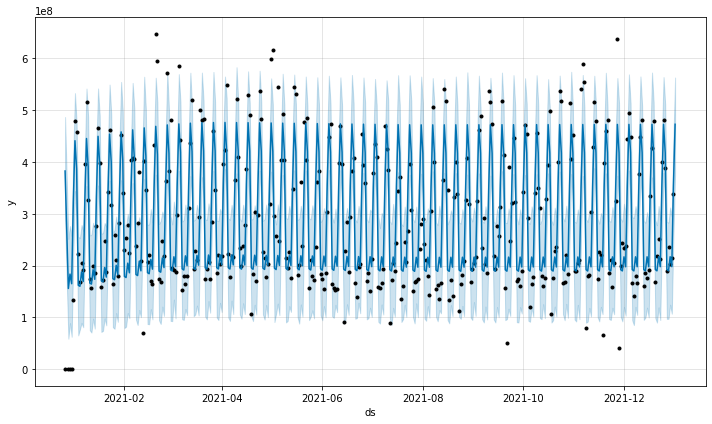

In [ ]:
model.plot(pred)
plt.show()

#어느 정도 된 것 같은데....이상치들 때문에 좀 안 이쁘게 나온 듯

트레인 셋 만들기

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_set,test_set=train_test_split(lotte,test_size=0.2,random_state=42)
print(len(train_set), "train +", len(test_set), "test")

3704037 train + 926010 test


## 쓴 금액으로 고객을 나눠보자!

In [ ]:
spend_lotte = data.groupby(['cust']).sum()
spend_lotte.head()

,chnl_dv,buy_am,buy_ct
cust,,,
M000034966,52,658020.0,63.0
M000059535,2,46000.0,0.0
M000136117,137,27611030.0,114.0
M000201112,21,53120.0,30.0
M000225114,169,2253900.0,182.0


In [ ]:
spend_lotte.describe()

,chnl_dv,buy_am,buy_ct
count,29756.000000,2.975600e+04,29756.000000
mean,171.169747,3.586164e+06,192.958126
std,251.242002,1.139046e+07,304.428519
min,1.000000,1.000000e+01,0.000000
25%,21.000000,3.367388e+05,19.000000
50%,86.000000,1.290540e+06,91.000000
75%,220.000000,3.205749e+06,251.000000
max,12454.000000,4.098211e+08,18238.000000


In [ ]:
log_spend.boxplot()

AttributeError: ignored

In [ ]:
log_spend = np.log(spend_lotte['buy_am'])
log_spend.head()

cust
M000034966    13.396991
M000059535    10.736397
M000136117    17.133726
M000201112    10.880309
M000225114    14.628173
Name: buy_am, dtype: float64